In [1]:
!pip install konlpy
!pip install wandb
import os
import re
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from konlpy.tag import Okt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


import wandb
from wandb.integration.keras.callbacks import WandbMetricsLogger
wandb.login()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.1/494.1 kB 23.0 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: bth0114 (jiwoong-team) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [2]:




from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#학습 데이터 경로
train_paths = {
    "eda_normal_conversation":  "https://raw.githubusercontent.com/bth0114/AIFFEL_DLThon_DKTC_online13/main/data/aug_csv/eda_normal_conversation.csv",
    "conversations_aihub": "https://raw.githubusercontent.com/bth0114/AIFFEL_DLThon_DKTC_online13/main/data/raw_csv/conversations_aihub.csv",
    "merged_train": "https://raw.githubusercontent.com/bth0114/AIFFEL_DLThon_DKTC_online13/main/data/raw_csv/merged_train.csv",
    "merged_train_train": "https://raw.githubusercontent.com/bth0114/AIFFEL_DLThon_DKTC_online13/main/data/raw_csv/merged_train_train.csv",
    "merged_train_val": "https://raw.githubusercontent.com/bth0114/AIFFEL_DLThon_DKTC_online13/main/data/raw_csv/merged_train_val.csv",
    "aug_synonym_train_only" : "https://raw.githubusercontent.com/bth0114/AIFFEL_DLThon_DKTC_online13/main/data/aug_csv/aug_synonym_train_only.csv",
    "aug_KoEDA_train_only":"https://raw.githubusercontent.com/bth0114/AIFFEL_DLThon_DKTC_online13/main/data/aug_csv/aug_KoEDA_train_only.csv",
    "aug_plus": "https://raw.githubusercontent.com/bth0114/AIFFEL_DLThon_DKTC_online13/main/data/aug_csv/aug_plus_train.csv",
    "aug_synonym": "https://raw.githubusercontent.com/bth0114/AIFFEL_DLThon_DKTC_online13/main/data/aug_csv/aug_synonym_train_only.csv",
    "eda_only": "https://raw.githubusercontent.com/bth0114/AIFFEL_DLThon_DKTC_online13/main/data/aug_csv/eda_only.csv",
    "final_allclass": "https://raw.githubusercontent.com/bth0114/AIFFEL_DLThon_DKTC_online13/main/data/aug_csv/final_train_allclass_eda.csv"

}

# 제출용 test 데이터 경로
test_url = "https://raw.githubusercontent.com/bth0114/AIFFEL_DLThon_DKTC_online13/main/data/raw_csv/test.csv"

In [3]:
# 1. 데이터 불러오기
df_merged_train_train = pd.read_csv(train_paths["merged_train_train"])
df_merged_train_val = pd.read_csv(train_paths["merged_train_val"])
df_conversations_aihub = pd.read_csv(train_paths["conversations_aihub"])
df_syn = pd.read_csv(train_paths["aug_synonym"])
df_eda = pd.read_csv(train_paths["eda_only"])
df_syn_only = pd.read_csv(train_paths["aug_synonym_train_only"])
df_eda_only = pd.read_csv(train_paths["aug_KoEDA_train_only"])
df_eda_normal_conversation=pd.read_csv(train_paths["eda_normal_conversation"])

In [4]:
# 2. 라벨 인코딩

# 원하는 정수 순서 지정
custom_label_order = {
    '협박 대화': 0,
    '갈취 대화': 1,
    '직장 내 괴롭힘 대화': 2,
    '기타 괴롭힘 대화': 3,
    '일반 대화': 4
}

# 원-핫이 아니라 문자열 클래스인 경우 바로 정수로 변환
y_train_int = df_merged_train_train['class'].map(custom_label_order).values
y_val_int = df_merged_train_val['class'].map(custom_label_order).values

In [5]:
# 훈련셋,검증셋 분리

# 1. 입력 텍스트
X_train_raw = df_merged_train_train["conversation"]
X_val_raw = df_merged_train_val["conversation"]

# 2. 클래스 → 정수 인코딩
y_train = df_merged_train_train["class"].map(custom_label_order).values
y_val = df_merged_train_val["class"].map(custom_label_order).values

In [6]:
X_eda_only = df_eda_only['conversation'].tolist()
X_eda_conversation = df_eda_normal_conversation['conversation'].tolist()
y_eda_only = df_eda_only['class'].map(custom_label_order).values
y_eda_conversation = df_eda_normal_conversation['class'].map(custom_label_order).values
# 조합 생성
X1 = X_train_raw.tolist()
y1 = y_train

X2 = X1 + X_eda_only + X_eda_conversation
y2 = np.concatenate([y_train, y_eda_only,y_eda_conversation])

# 예시 확인
print(f"샘플 수\nX1: {len(X1)}, X2: {len(X2)}")

샘플 수
X1: 3709, X2: 11127


In [7]:
df_kakao_16000 = pd.read_csv(train_paths["conversations_aihub"]).iloc[:16000]
df_kakao_8000 = pd.read_csv(train_paths["conversations_aihub"]).iloc[:8000]
df_kakao_2000 = pd.read_csv(train_paths["conversations_aihub"]).iloc[:2000]
df_kakao_1000 = pd.read_csv(train_paths["conversations_aihub"]).iloc[:1000]

df_raw = df_merged_train_train[df_merged_train_train['class'] != '일반 대화'] # 일반 대화 샘플 삭제

df_combined_16000 = pd.concat([df_raw, df_eda_only, df_kakao_16000], ignore_index=True)
df_combined_8000 = pd.concat([df_raw, df_eda_only, df_kakao_8000], ignore_index=True)
df_combined_2000 = pd.concat([df_raw, df_eda_only, df_kakao_2000], ignore_index=True)
df_combined_1000 = pd.concat([df_raw, df_kakao_1000], ignore_index=True)


In [8]:
X_eda_only = df_eda_only['conversation'].tolist()
X_eda_conversation = df_eda_normal_conversation['conversation'].tolist()
y_eda_only = df_eda_only['class'].map(custom_label_order).values
y_eda_conversation = df_eda_normal_conversation['class'].map(custom_label_order).values


# 조합 생성
X3 = df_combined_1000['conversation'].tolist()
y3 = df_combined_1000['class'].map(custom_label_order).values

X4 = df_combined_2000['conversation'].tolist()
y4 = df_combined_2000['class'].map(custom_label_order).values

X5 = df_combined_8000['conversation'].tolist()
y5 = df_combined_8000['class'].map(custom_label_order).values

X6 = df_combined_16000['conversation'].tolist()
y6 = df_combined_16000['class'].map(custom_label_order).values

# 예시 확인
print(f"샘플 수\nX3: {len(X3)}, X4: {len(X4)}, X5: {len(X5)}, X6: {len(X6)}")

샘플 수
X3: 4076, X4: 11228, X5: 17228, X6: 25228


In [9]:
!pip install datasets transformers scikit-learn --quiet

import pandas as pd
import numpy as np
import torch
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    ElectraForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from sklearn.metrics import accuracy_score, f1_score, classification_report
from tensorflow.keras.utils import to_categorical
import re

# 모델 설정
MODEL_NAME = "beomi/KcELECTRA-base-v2022"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ElectraForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=5).to(device)

# 전처리 함수

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = sentence.replace('\n', ' ').replace('\r', ' ')
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^ㄱ-ㅎ가-힣ㅏ-ㅣ?.!,]+", " ", sentence)
    return sentence.strip()

def preprocessing(texts, tokenizer, padded_max_len):
    encodings = tokenizer(
        texts,
        truncation=True,
        padding='max_length',
        max_length=padded_max_len,
        return_tensors='tf'
    )
    return {
        'input_ids': encodings['input_ids'],
        'attention_mask': encodings['attention_mask']
    }

# 토크나이즈 함수 (huggingface Trainer용)
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

# 데이터프레임 전처리 함수
def preprocess_train(df):
    df.columns = df.columns.str.strip().str.lower()
    df["label"] = df["class"].map(custom_label_order)  # Dict 필요
    return Dataset.from_pandas(df.rename(columns={"conversation": "text"}))



def preprocess_test(df):
    df.columns = df.columns.str.strip().str.lower()
    return Dataset.from_pandas(df.rename(columns={"conversation": "text"}))

# One-hot 인코딩
y1_cat = to_categorical(y1, num_classes=5)
y2_cat = to_categorical(y2, num_classes=5)
y3_cat = to_categorical(y3, num_classes=5)
y4_cat = to_categorical(y4, num_classes=5)
y5_cat = to_categorical(y5, num_classes=5)
y6_cat = to_categorical(y6, num_classes=5)
y_val_cat = to_categorical(y_val, num_classes=5)

# 텍스트 전처리

# 전처리 적용 후 토크나이징
X1_clean = [preprocess_sentence(s) for s in X1]
X2_clean = [preprocess_sentence(s) for s in X2]
X3_clean = [preprocess_sentence(s) for s in X3]
X4_clean = [preprocess_sentence(s) for s in X4]
X5_clean = [preprocess_sentence(s) for s in X5]
X6_clean = [preprocess_sentence(s) for s in X6]
X_val_clean = [preprocess_sentence(s) for s in X_val_raw.tolist()]

# 토크나이징 적용
X1_enc = preprocessing(X1_clean, tokenizer, padded_max_len=128)
X2_enc = preprocessing(X2_clean, tokenizer, padded_max_len=128)
X3_enc = preprocessing(X3_clean, tokenizer, padded_max_len=128)
X4_enc = preprocessing(X4_clean, tokenizer, padded_max_len=128)
X5_enc = preprocessing(X5_clean, tokenizer, padded_max_len=128)
X6_enc = preprocessing(X6_clean, tokenizer, padded_max_len=128)
X_val_enc = preprocessing(X_val_clean, tokenizer, padded_max_len=128)



def compute_metrics(pred):
    preds = np.argmax(pred.predictions, axis=1)
    labels = pred.label_ids
    acc = accuracy_score(labels, preds)
    report = classification_report(labels, preds, output_dict=True, zero_division=0)

    metrics = {
        "Accuray f1": report["weighted avg"]["f1-score"],
        "accuray": acc,
    }

    # 클래스별 f1
    for i, name in enumerate(label_names):
        f1_val = report.get(str(i), {}).get("f1-score", 0)
        metrics[f"{name}_f1"] = f1_val

    return metrics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12=

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/288 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/504 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/450k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/511M [00:00<?, ?B/s]

In [10]:
from transformers import TrainingArguments, Trainer
from sklearn.model_selection import train_test_split

dataset_names = ["원본", "원본+EDA", "원본+1000", "원본+EDA+2000","원본+EDA+8000","원본+EDA+16000"]
X_list = [X1_clean, X2_clean, X3_clean, X4_clean, X5_clean, X6_clean]
y_list = [y1, y2, y3, y4, y5, y6]

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

for i, (X, y, name) in enumerate(zip(X_list, y_list, dataset_names), 1):
    print(f"\n▶ 모델 {i}: {name}")

    #  여기가 핵심! X, y를 train/val로 분리
    X_train_split, _, y_train_split, _ = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # 공통 검증셋은 y_val, X_val_raw 그대로 사용
    train_df = pd.DataFrame({"text": X_train_split, "label": y_train_split})
    val_df = pd.DataFrame({"text": X_val_clean, "label": y_val})   # 여기서 val은 고정

    # Hugging Face Dataset + Tokenize
    train_dataset = Dataset.from_pandas(train_df).map(tokenize_function, batched=True)
    val_dataset = Dataset.from_pandas(val_df).map(tokenize_function, batched=True)

    model = ElectraForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=5).to(device)

    training_args = TrainingArguments(
        output_dir=f"./results/model_{i}",
        num_train_epochs=2,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        learning_rate=3e-5,
        weight_decay=0.01,
        logging_dir=f"./results/logs_{i}",
        logging_steps=500
    )
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )

    trainer.train()
    trainer.save_model(f"./results/model_{i}")



▶ 모델 1: 원본


Map:   0%|          | 0/2967 [00:00<?, ? examples/s]

Map:   0%|          | 0/928 [00:00<?, ? examples/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-10-f762b774abb8>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss



▶ 모델 2: 원본+EDA


Map:   0%|          | 0/8901 [00:00<?, ? examples/s]

Map:   0%|          | 0/928 [00:00<?, ? examples/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-10-f762b774abb8>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.484000
1000,0.130200



▶ 모델 3: 원본+1000


Map:   0%|          | 0/3260 [00:00<?, ? examples/s]

Map:   0%|          | 0/928 [00:00<?, ? examples/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-10-f762b774abb8>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss



▶ 모델 4: 원본+EDA+2000


Map:   0%|          | 0/8982 [00:00<?, ? examples/s]

Map:   0%|          | 0/928 [00:00<?, ? examples/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-10-f762b774abb8>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.505800
1000,0.156500



▶ 모델 5: 원본+EDA+8000


Map:   0%|          | 0/13782 [00:00<?, ? examples/s]

Map:   0%|          | 0/928 [00:00<?, ? examples/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-10-f762b774abb8>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.419400
1000,0.163200
1500,0.080200



▶ 모델 6: 원본+EDA+16000


Map:   0%|          | 0/20182 [00:00<?, ? examples/s]

Map:   0%|          | 0/928 [00:00<?, ? examples/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-10-f762b774abb8>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.400900
1000,0.156600
1500,0.109100
2000,0.065100
2500,0.051200


In [11]:
from sklearn.metrics import classification_report

# 1. 검증셋 준비
val_df = pd.DataFrame({"text": X_val_raw.tolist(), "label": y_val})
val_dataset = Dataset.from_pandas(val_df).map(tokenize_function, batched=True)

# 2. 라벨 이름 설정
label_names = list(custom_label_order.keys())

# 3. 모델별 평가
print("\n✅ 모델별 검증 성능 비교")
for i, name in enumerate(dataset_names, 1):
    print(f"\n▶ 모델 {i}: {name}")

    # 모델 불러오기
    model_path = f"./results/model_{i}"
    model = ElectraForSequenceClassification.from_pretrained(model_path).to(device)

    # 평가용 Trainer
    trainer = Trainer(
        model=model,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    # 예측
    preds = trainer.predict(val_dataset)
    y_pred = np.argmax(preds.predictions, axis=1)

    # 평가 리포트 출력
    print(classification_report(y_val, y_pred, target_names=label_names))

Map:   0%|          | 0/928 [00:00<?, ? examples/s]


✅ 모델별 검증 성능 비교

▶ 모델 1: 원본


<ipython-input-11-ff3368bdd3f0>:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


              precision    recall  f1-score   support

       협박 대화       0.88      0.85      0.87       179
       갈취 대화       0.88      0.85      0.86       195
 직장 내 괴롭힘 대화       0.97      0.94      0.96       194
   기타 괴롭힘 대화       0.82      0.89      0.85       202
       일반 대화       0.99      0.99      0.99       158

    accuracy                           0.90       928
   macro avg       0.91      0.91      0.91       928
weighted avg       0.90      0.90      0.90       928


▶ 모델 2: 원본+EDA


<ipython-input-11-ff3368bdd3f0>:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


              precision    recall  f1-score   support

       협박 대화       0.87      0.87      0.87       179
       갈취 대화       0.86      0.89      0.87       195
 직장 내 괴롭힘 대화       0.97      0.97      0.97       194
   기타 괴롭힘 대화       0.91      0.86      0.88       202
       일반 대화       0.99      1.00      0.99       158

    accuracy                           0.92       928
   macro avg       0.92      0.92      0.92       928
weighted avg       0.92      0.92      0.92       928


▶ 모델 3: 원본+1000


<ipython-input-11-ff3368bdd3f0>:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


              precision    recall  f1-score   support

       협박 대화       0.85      0.84      0.85       179
       갈취 대화       0.81      0.89      0.85       195
 직장 내 괴롭힘 대화       0.94      0.96      0.95       194
   기타 괴롭힘 대화       0.84      0.83      0.84       202
       일반 대화       0.98      0.87      0.92       158

    accuracy                           0.88       928
   macro avg       0.88      0.88      0.88       928
weighted avg       0.88      0.88      0.88       928


▶ 모델 4: 원본+EDA+2000


<ipython-input-11-ff3368bdd3f0>:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


              precision    recall  f1-score   support

       협박 대화       0.84      0.91      0.87       179
       갈취 대화       0.88      0.86      0.87       195
 직장 내 괴롭힘 대화       0.94      0.97      0.96       194
   기타 괴롭힘 대화       0.84      0.84      0.84       202
       일반 대화       0.97      0.89      0.93       158

    accuracy                           0.89       928
   macro avg       0.90      0.89      0.89       928
weighted avg       0.89      0.89      0.89       928


▶ 모델 5: 원본+EDA+8000


<ipython-input-11-ff3368bdd3f0>:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


              precision    recall  f1-score   support

       협박 대화       0.88      0.90      0.89       179
       갈취 대화       0.88      0.87      0.87       195
 직장 내 괴롭힘 대화       0.94      0.97      0.96       194
   기타 괴롭힘 대화       0.86      0.86      0.86       202
       일반 대화       0.98      0.94      0.96       158

    accuracy                           0.91       928
   macro avg       0.91      0.91      0.91       928
weighted avg       0.91      0.91      0.91       928


▶ 모델 6: 원본+EDA+16000


<ipython-input-11-ff3368bdd3f0>:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


              precision    recall  f1-score   support

       협박 대화       0.88      0.89      0.88       179
       갈취 대화       0.86      0.88      0.87       195
 직장 내 괴롭힘 대화       0.96      0.96      0.96       194
   기타 괴롭힘 대화       0.88      0.83      0.85       202
       일반 대화       0.94      0.95      0.94       158

    accuracy                           0.90       928
   macro avg       0.90      0.90      0.90       928
weighted avg       0.90      0.90      0.90       928



In [12]:
from wandb.integration.keras import WandbCallback
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#  공통 함수 정의
def log_model_to_wandb(model, run_name, notes, X_train, y_train, X_val, y_val, ordered_columns):
    import wandb
    from sklearn.metrics import classification_report



    run = wandb.init(
    entity="jiwoong-team",
    project="DLThon-DKTC",
    name=run_name,
    notes=notes,
    config=dict(
        architecture="KcELECTRA",
        input_length=128,
        epochs=10,
        batch_size=32
    ),
    reinit=True,
    settings=wandb.Settings(_disable_stats=True)
    )


    #  예측 결과 평가
    y_pred = model.predict(X_val)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y_val, axis=1)

    #  classification report 테이블 생성
    report = classification_report(y_true_labels, y_pred_labels, target_names=ordered_columns, output_dict=True)
    columns = ["class", "precision", "recall", "f1-score", "support"]
    data = []
    for label, metrics in report.items():
        if isinstance(metrics, dict):
            row = [label] + [metrics.get(col, None) for col in columns[1:]]
            data.append(row)

    table = wandb.Table(columns=columns, data=data)

    wandb.log({
    "macro_f1": float(report["macro avg"]["f1-score"]),
    "accuracy": float(report["accuracy"]),
    "threat_f1": float(report["협박 대화"]["f1-score"]),
    "extortion_f1": float(report["갈취 대화"]["f1-score"]),
    "workplace_bullying_f1": float(report["직장 내 괴롭힘 대화"]["f1-score"]),
    "other_bullying_f1": float(report["기타 괴롭힘 대화"]["f1-score"]),
    "general_conversation_f1": float(report["일반 대화"]["f1-score"]),
    })


    run.finish()


In [13]:
ordered_columns = [
    "협박 대화",
    "갈취 대화",
    "직장 내 괴롭힘 대화",
    "기타 괴롭힘 대화",
    "일반 대화"
]

from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding
from sklearn.metrics import classification_report
import torch

def log_model_to_wandb(model, run_name, notes, X_train, y_train, X_val, y_val, ordered_columns):
    import wandb
    from transformers import AutoTokenizer
    from datasets import Dataset
    from tqdm import tqdm

    run = wandb.init(
        entity="jiwoong-team",
        project="DLThon-DKTC",
        name=run_name,
        notes=notes,
        config=dict(
            architecture="KcELECTRA",
            input_length=128,
            epochs=10,
            batch_size=32
        ),
        reinit=True,
        settings=wandb.Settings(_disable_stats=True)
    )

    # 토크나이즈
    val_df = pd.DataFrame({"text": X_val, "label": y_val})
    val_dataset = Dataset.from_pandas(val_df).map(tokenize_function, batched=True)
    val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask'])

    # 평가
    model.eval()
    y_preds = []
    y_trues = []

    dataloader = DataLoader(val_dataset, batch_size=32, collate_fn=data_collator)

    for batch in tqdm(dataloader, desc="Evaluating"):
        input_ids = batch["input_ids"].to(model.device)
        attention_mask = batch["attention_mask"].to(model.device)
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        y_preds.extend(preds)

    y_true_labels = y_val
    y_pred_labels = y_preds

    # classification report
    report = classification_report(y_true_labels, y_pred_labels, target_names=ordered_columns, output_dict=True)
    columns = ["class", "precision", "recall", "f1-score", "support"]
    data = []
    for label, metrics in report.items():
        if isinstance(metrics, dict):
            row = [label] + [metrics.get(col, None) for col in columns[1:]]
            data.append(row)

    table = wandb.Table(columns=columns, data=data)

    wandb.log({
        "macro_f1": float(report["macro avg"]["f1-score"]),
        "accuracy": float(report["accuracy"]),
        "threat_f1": float(report["협박 대화"]["f1-score"]),
        "extortion_f1": float(report["갈취 대화"]["f1-score"]),
        "workplace_bullying_f1": float(report["직장 내 괴롭힘 대화"]["f1-score"]),
        "other_bullying_f1": float(report["기타 괴롭힘 대화"]["f1-score"]),
        "general_conversation_f1": float(report["일반 대화"]["f1-score"]),
        "classification_report": table
    })

    run.finish()


In [14]:
model1 = ElectraForSequenceClassification.from_pretrained("./results/model_1").to(device)
model2 = ElectraForSequenceClassification.from_pretrained("./results/model_2").to(device)
model3 = ElectraForSequenceClassification.from_pretrained("./results/model_3").to(device)
model4 = ElectraForSequenceClassification.from_pretrained("./results/model_4").to(device)
model5 = ElectraForSequenceClassification.from_pretrained("./results/model_5").to(device)
model6 = ElectraForSequenceClassification.from_pretrained("./results/model_6").to(device)
# 모델 1: 원본 데이터만
log_model_to_wandb(
    model1,
    run_name="KcELECTRA_original_only",
    notes="원본 데이터만 사용",
    X_train=X1, y_train=y1,
    X_val=X_val_raw, y_val=y_val,
    ordered_columns=ordered_columns
)

# 모델 2: 원본 + EDA
log_model_to_wandb(
    model2,
    run_name="KcELECTRA_eda",
    notes="원본 + EDA 증강",
    X_train=X2, y_train=y2,
    X_val=X_val_raw, y_val=y_val,
    ordered_columns=ordered_columns
)
# 모델 2: 원본 + EDA
log_model_to_wandb(
    model3,
    run_name="KcELECTRA_eda",
    notes="원본 + 1000",
    X_train=X3, y_train=y3,
    X_val=X_val_raw, y_val=y_val,
    ordered_columns=ordered_columns
)

# 모델 4:
log_model_to_wandb(
    model4,
    run_name="KcELECTRA_synonym_eda",
    notes="원본 + 2000 + EDA 증강",
    X_train=X4_enc, y_train=y4_cat,
    X_val=X_val_raw, y_val=y_val,
    ordered_columns=ordered_columns
)
# 모델 5
log_model_to_wandb(
    model5,
    run_name="KcELECTRA_synonym_eda",
    notes="원본 + 8000 + EDA 증강",
    X_train=X5, y_train=y5,
    X_val=X_val_raw, y_val=y_val,
    ordered_columns=ordered_columns
)
# 모델 4: 원본 + Synonym + EDA
log_model_to_wandb(
    model6,
    run_name="KcELECTRA_16000_eda",
    notes="원본 + 160000 + EDA 증강",
    X_train=X6, y_train=y6,
    X_val=X_val_raw, y_val=y_val,
    ordered_columns=ordered_columns
)



test/Accuray f1,▆█▁▃▆▅
test/accuray,▆█▁▃▆▅
test/loss,▁▄▆█▇▇
test/model_preparation_time,█▄▇▂▁▁
test/runtime,▇█▄▃▁▁
test/samples_per_second,▁▁▅▆██
test/steps_per_second,▁▁▅▆██
test/갈취 대화_f1,▅█▁▇▇▆
test/기타 괴롭힘 대화_f1,▄█▁▁▅▄
test/일반 대화_f1,██▁▂▅▃
test/직장 내 괴롭힘 대화_f1,▃█▁▃▃▅


wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Map:   0%|          | 0/928 [00:00<?, ? examples/s]

Evaluating: 100%|██████████| 29/29 [00:06<00:00,  4.39it/s]


accuracy,▁
extortion_f1,▁
general_conversation_f1,▁
macro_f1,▁
other_bullying_f1,▁
threat_f1,▁
workplace_bullying_f1,▁
accuracy,0.90302
extortion_f1,0.86387
general_conversation_f1,0.99054
macro_f1,0.90648


Map:   0%|          | 0/928 [00:00<?, ? examples/s]

Evaluating: 100%|██████████| 29/29 [00:06<00:00,  4.53it/s]


accuracy,▁
extortion_f1,▁
general_conversation_f1,▁
macro_f1,▁
other_bullying_f1,▁
threat_f1,▁
workplace_bullying_f1,▁
accuracy,0.91595
extortion_f1,0.87437
general_conversation_f1,0.99371
macro_f1,0.91838


Map:   0%|          | 0/928 [00:00<?, ? examples/s]

Evaluating: 100%|██████████| 29/29 [00:06<00:00,  4.51it/s]


accuracy,▁
extortion_f1,▁
general_conversation_f1,▁
macro_f1,▁
other_bullying_f1,▁
threat_f1,▁
workplace_bullying_f1,▁
accuracy,0.87823
extortion_f1,0.84804
general_conversation_f1,0.91946
macro_f1,0.88001


Map:   0%|          | 0/928 [00:00<?, ? examples/s]

Evaluating: 100%|██████████| 29/29 [00:06<00:00,  4.51it/s]


accuracy,▁
extortion_f1,▁
general_conversation_f1,▁
macro_f1,▁
other_bullying_f1,▁
threat_f1,▁
workplace_bullying_f1,▁
accuracy,0.89116
extortion_f1,0.86979
general_conversation_f1,0.93069
macro_f1,0.89291


Map:   0%|          | 0/928 [00:00<?, ? examples/s]

Evaluating: 100%|██████████| 29/29 [00:06<00:00,  4.46it/s]


accuracy,▁
extortion_f1,▁
general_conversation_f1,▁
macro_f1,▁
other_bullying_f1,▁
threat_f1,▁
workplace_bullying_f1,▁
accuracy,0.90517
extortion_f1,0.87113
general_conversation_f1,0.95793
macro_f1,0.90734


Map:   0%|          | 0/928 [00:00<?, ? examples/s]

Evaluating: 100%|██████████| 29/29 [00:06<00:00,  4.30it/s]


accuracy,▁
extortion_f1,▁
general_conversation_f1,▁
macro_f1,▁
other_bullying_f1,▁
threat_f1,▁
workplace_bullying_f1,▁
accuracy,0.90086
extortion_f1,0.86869
general_conversation_f1,0.9434
macro_f1,0.90236


Map:   0%|          | 0/928 [00:00<?, ? examples/s]


 모델별 confusion matrix 및 classification report

 모델 1: 원본


<ipython-input-15-48dff5dd9374>:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)


Confusion Matrix:
[[153  10   3  13   0]
 [ 10 165   1  18   1]
 [  1   0 183   9   1]
 [  9  11   2 180   0]
 [  0   1   0   0 157]]


/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 54801 (\N{HANGUL SYLLABLE HYEOB}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 48149 (\N{HANGUL SYLLABLE BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44040 (\N{HANGUL SYLLABLE GAL}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 52712 (\N{HANGUL SYLLABLE CWI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/u

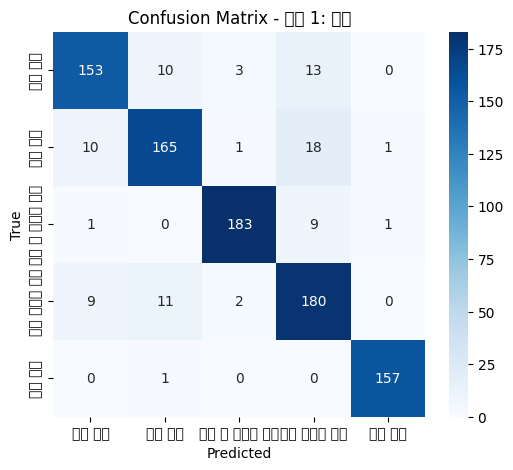

Classification Report:
              precision    recall  f1-score   support

       협박 대화       0.88      0.85      0.87       179
       갈취 대화       0.88      0.85      0.86       195
 직장 내 괴롭힘 대화       0.97      0.94      0.96       194
   기타 괴롭힘 대화       0.82      0.89      0.85       202
       일반 대화       0.99      0.99      0.99       158

    accuracy                           0.90       928
   macro avg       0.91      0.91      0.91       928
weighted avg       0.90      0.90      0.90       928


 모델 2: 원본+EDA


<ipython-input-15-48dff5dd9374>:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)


Confusion Matrix:
[[156  14   4   5   0]
 [  9 174   1  10   1]
 [  1   1 188   3   1]
 [ 13  14   1 174   0]
 [  0   0   0   0 158]]


/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 54801 (\N{HANGUL SYLLABLE HYEOB}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 48149 (\N{HANGUL SYLLABLE BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44040 (\N{HANGUL SYLLABLE GAL}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 52712 (\N{HANGUL SYLLABLE CWI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/u

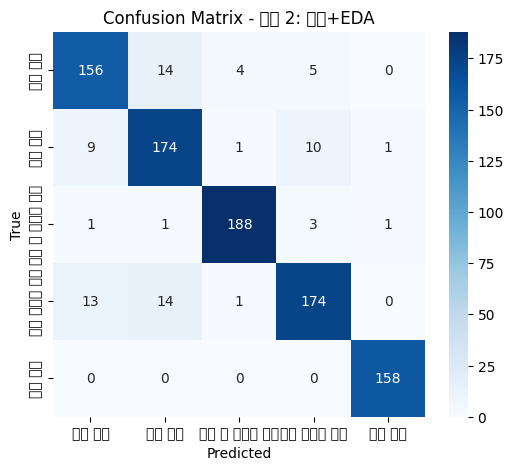

Classification Report:
              precision    recall  f1-score   support

       협박 대화       0.87      0.87      0.87       179
       갈취 대화       0.86      0.89      0.87       195
 직장 내 괴롭힘 대화       0.97      0.97      0.97       194
   기타 괴롭힘 대화       0.91      0.86      0.88       202
       일반 대화       0.99      1.00      0.99       158

    accuracy                           0.92       928
   macro avg       0.92      0.92      0.92       928
weighted avg       0.92      0.92      0.92       928


 모델 3: 원본+1000


<ipython-input-15-48dff5dd9374>:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)


Confusion Matrix:
[[150  16   3  10   0]
 [ 11 173   1  10   0]
 [  1   1 187   5   0]
 [ 11  16   4 168   3]
 [  3   7   4   7 137]]


/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 54801 (\N{HANGUL SYLLABLE HYEOB}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 48149 (\N{HANGUL SYLLABLE BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44040 (\N{HANGUL SYLLABLE GAL}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 52712 (\N{HANGUL SYLLABLE CWI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/u

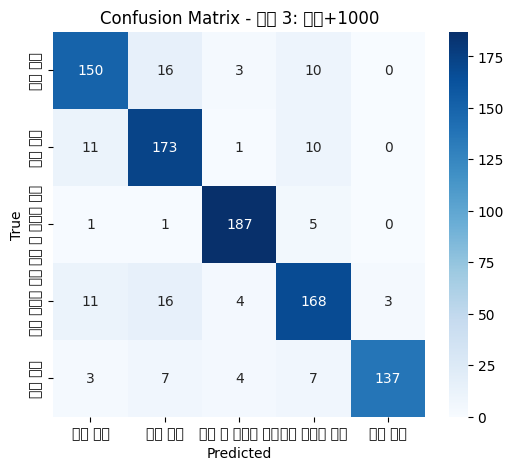

Classification Report:
              precision    recall  f1-score   support

       협박 대화       0.85      0.84      0.85       179
       갈취 대화       0.81      0.89      0.85       195
 직장 내 괴롭힘 대화       0.94      0.96      0.95       194
   기타 괴롭힘 대화       0.84      0.83      0.84       202
       일반 대화       0.98      0.87      0.92       158

    accuracy                           0.88       928
   macro avg       0.88      0.88      0.88       928
weighted avg       0.88      0.88      0.88       928


 모델 4: 원본+EDA+2000


<ipython-input-15-48dff5dd9374>:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)


Confusion Matrix:
[[162   8   2   7   0]
 [ 13 167   1  12   2]
 [  2   0 188   4   0]
 [ 15  11   5 169   2]
 [  2   3   3   9 141]]


/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 54801 (\N{HANGUL SYLLABLE HYEOB}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 48149 (\N{HANGUL SYLLABLE BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44040 (\N{HANGUL SYLLABLE GAL}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 52712 (\N{HANGUL SYLLABLE CWI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/u

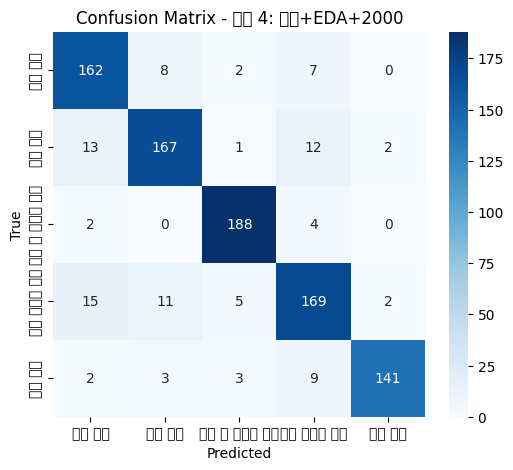

Classification Report:
              precision    recall  f1-score   support

       협박 대화       0.84      0.91      0.87       179
       갈취 대화       0.88      0.86      0.87       195
 직장 내 괴롭힘 대화       0.94      0.97      0.96       194
   기타 괴롭힘 대화       0.84      0.84      0.84       202
       일반 대화       0.97      0.89      0.93       158

    accuracy                           0.89       928
   macro avg       0.90      0.89      0.89       928
weighted avg       0.89      0.89      0.89       928


 모델 5: 원본+EDA+8000


<ipython-input-15-48dff5dd9374>:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)


Confusion Matrix:
[[161   8   4   6   0]
 [ 11 169   2  10   3]
 [  1   0 188   5   0]
 [ 10  14   4 174   0]
 [  0   2   1   7 148]]


/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 54801 (\N{HANGUL SYLLABLE HYEOB}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 48149 (\N{HANGUL SYLLABLE BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44040 (\N{HANGUL SYLLABLE GAL}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 52712 (\N{HANGUL SYLLABLE CWI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/u

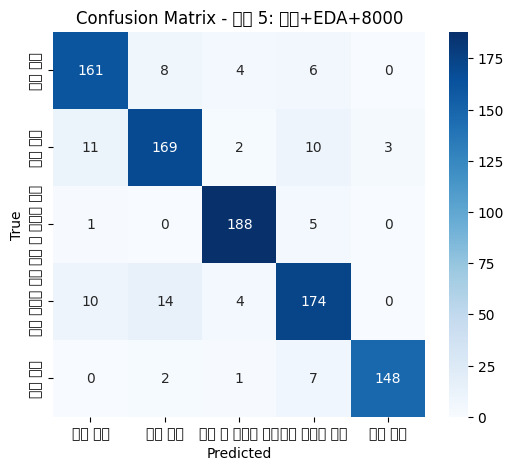

Classification Report:
              precision    recall  f1-score   support

       협박 대화       0.88      0.90      0.89       179
       갈취 대화       0.88      0.87      0.87       195
 직장 내 괴롭힘 대화       0.94      0.97      0.96       194
   기타 괴롭힘 대화       0.86      0.86      0.86       202
       일반 대화       0.98      0.94      0.96       158

    accuracy                           0.91       928
   macro avg       0.91      0.91      0.91       928
weighted avg       0.91      0.91      0.91       928


 모델 6: 원본+EDA+16000


<ipython-input-15-48dff5dd9374>:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)


Confusion Matrix:
[[159  12   3   5   0]
 [  9 172   1   9   4]
 [  1   1 187   4   1]
 [ 12  14   3 168   5]
 [  0   2   1   5 150]]


/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 54801 (\N{HANGUL SYLLABLE HYEOB}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 48149 (\N{HANGUL SYLLABLE BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44040 (\N{HANGUL SYLLABLE GAL}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 52712 (\N{HANGUL SYLLABLE CWI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/u

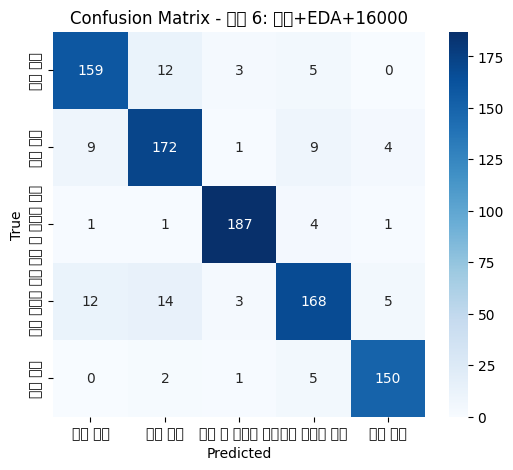

Classification Report:
              precision    recall  f1-score   support

       협박 대화       0.88      0.89      0.88       179
       갈취 대화       0.86      0.88      0.87       195
 직장 내 괴롭힘 대화       0.96      0.96      0.96       194
   기타 괴롭힘 대화       0.88      0.83      0.85       202
       일반 대화       0.94      0.95      0.94       158

    accuracy                           0.90       928
   macro avg       0.90      0.90      0.90       928
weighted avg       0.90      0.90      0.90       928



In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 검증셋 준비
val_df = pd.DataFrame({"text": X_val_raw.tolist(), "label": y_val})
val_dataset = Dataset.from_pandas(val_df).map(tokenize_function, batched=True)

print("\n 모델별 confusion matrix 및 classification report")
for i, name in enumerate(dataset_names, 1):
    print(f"\n 모델 {i}: {name}")

    # 모델 불러오기
    model_path = f"./results/model_{i}"
    model = ElectraForSequenceClassification.from_pretrained(model_path).to(device)

    # 평가용 Trainer
    trainer = Trainer(model=model, tokenizer=tokenizer)

    # 예측 수행
    preds = trainer.predict(val_dataset)
    y_pred = np.argmax(preds.predictions, axis=1)
    y_true = y_val

    # confusion matrix 출력
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # 시각화
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=ordered_columns, yticklabels=ordered_columns)
    plt.title(f"Confusion Matrix - 모델 {i}: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=ordered_columns))


In [16]:
test_df = pd.read_csv(test_url)
test_df.columns = test_df.columns.str.strip().str.lower()
test_df = test_df.rename(columns={"conversation": "text"})
test_dataset = Dataset.from_pandas(test_df)
test_tokenized = test_dataset.map(lambda x: tokenizer(x["text"], padding="max_length", truncation=True, max_length=128), batched=True)

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [17]:
from sklearn.preprocessing import LabelEncoder
from transformers import ElectraForSequenceClassification, Trainer

# LabelEncoder 정의 및 학습
class_list = ["협박 대화", "갈취 대화", "직장 내 괴롭힘 대화", "기타 괴롭힘 대화", "일반 대화"]
le = LabelEncoder()
le.fit(class_list)

for i in range(1, 7):
    print(f"\n▶ 모델 {i} 예측 및 제출 파일 생성")

    # 모델 로드
    model_path = f"./results/model_{i}"
    model = ElectraForSequenceClassification.from_pretrained(model_path).to(device)

    # Trainer 설정
    trainer = Trainer(model=model, tokenizer=tokenizer)

    # 예측 수행
    preds = trainer.predict(test_tokenized)
    y_pred = np.argmax(preds.predictions, axis=1)

    # 클래스명으로 변환 후 → 다시 숫자 라벨로 (LabelEncoder 기준)
    class_names = le.inverse_transform(y_pred)
    label_ids = le.transform(class_names).astype(int)  # 그대로 평가용 target

    # 제출 파일 생성
    submission = pd.DataFrame({
        "idx": test_df["idx"],
        "target": label_ids  # 최종 숫자 라벨
    })

    submission.to_csv(f"submission_model{i}_final.csv", index=False, encoding="utf-8-sig")
    print(f"✅ submission_model{i}_final.csv 저장 완료")



▶ 모델 1 예측 및 제출 파일 생성


<ipython-input-17-0f38812df676>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)


✅ submission_model1_final.csv 저장 완료

▶ 모델 2 예측 및 제출 파일 생성


<ipython-input-17-0f38812df676>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)


✅ submission_model2_final.csv 저장 완료

▶ 모델 3 예측 및 제출 파일 생성


<ipython-input-17-0f38812df676>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)


✅ submission_model3_final.csv 저장 완료

▶ 모델 4 예측 및 제출 파일 생성


<ipython-input-17-0f38812df676>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)


✅ submission_model4_final.csv 저장 완료

▶ 모델 5 예측 및 제출 파일 생성


<ipython-input-17-0f38812df676>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)


✅ submission_model5_final.csv 저장 완료

▶ 모델 6 예측 및 제출 파일 생성


<ipython-input-17-0f38812df676>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)


✅ submission_model6_final.csv 저장 완료


In [20]:
# 분석 대상 파일 목록
submission_files = [f"submission_model{i}_final.csv" for i in range(1, 7)]

for file in submission_files:
    print(f"\n {file} 클래스별 분포")

    df = pd.read_csv(file)

    # 클래스별 개수 집계
    class_counts = df["target"].value_counts()

    # 정렬 후 출력 (가나다순)
    print(class_counts.sort_index())


 submission_model1_final.csv 클래스별 분포
target
0    104
1    108
2    110
3    164
4     14
Name: count, dtype: int64

 submission_model2_final.csv 클래스별 분포
target
0     96
1    120
2    117
3    154
4     13
Name: count, dtype: int64

 submission_model3_final.csv 클래스별 분포
target
0     97
1    114
2    108
3    127
4     54
Name: count, dtype: int64

 submission_model4_final.csv 클래스별 분포
target
0     99
1    110
2    109
3    119
4     63
Name: count, dtype: int64

 submission_model5_final.csv 클래스별 분포
target
0    102
1    103
2    108
3    117
4     70
Name: count, dtype: int64

 submission_model6_final.csv 클래스별 분포
target
0    100
1    103
2    105
3    110
4     82
Name: count, dtype: int64


In [ ]:

df = pd.read_csv("submission_model2_final.csv")
print(df.head(10
              ))  # 또는 display(df) in Jupyter

In [23]:
from google.colab import files
files.download("submission_model2_final.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
from google.colab import files
files.download("submission_model5_final.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>